In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir("/content/drive/MyDrive/RIR 2022 Synthetic Data") #changing working directory to google drive

In [15]:
!pip install hyperopt
!pip show hyperopt
! git clone https://github.com/hyperopt/hyperopt-sklearn
! cd hyperopt-sklearn/
! pip install hyperopt-sklearn/
! pip install hpsklearn
! pip show hpsklearn
os.chdir("/content/drive/MyDrive/RIR 2022 Synthetic Data")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Name: hyperopt
Version: 0.2.7
Summary: Distributed Asynchronous Hyperparameter Optimization
Home-page: https://hyperopt.github.io/hyperopt
Author: James Bergstra
Author-email: james.bergstra@gmail.com
License: BSD
Location: /usr/local/lib/python3.9/dist-packages
Requires: cloudpickle, future, networkx, numpy, py4j, scipy, six, tqdm
Required-by: hpsklearn
fatal: destination path 'hyperopt-sklearn' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./hyperopt-sklearn
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hpsklearn: filename=hpsklearn-1.0.3-py3-none-any.whl size=135027 sha256=d298bbf1f99d7cee6552fb1105781e9fad20ef97692d8fcbac59b5ee83fa5dec
  Stored in directory: /root/.cach

In [18]:
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.stem.snowball import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
nltk.download('punkt') # needed for apply function 
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
import gensim
import spacy
from random import sample
from hpsklearn import HyperoptEstimator, tfidf,multinomial_nb, sgd_classifier
from hyperopt import tpe
from hyperopt import hp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve,average_precision_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Loading the data and creating a learning dataset

In [4]:
df = pd.read_pickle("/content/drive/MyDrive/RIR 2022 Synthetic Data/538_Tweets_BertTopic_Labels.pkl")
df.head(2)

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category,year,normalized_tweet,label,sentence_embeddings,label_prob
0,8.920000e+17,CELLSSTITR,#bakerBREAKING : New Demands for Team Obama to...,Unknown,English,8/4/2017 13:28,8/4/2017 13:29,1988.0,800.0,807.0,NaN,Right,0.0,0.0,RightTroll,2017,#bakerBREAKING : New Demands for Team Obama to...,9,"[-0.06477942, 0.023317883, 0.01677053, -0.0454...",0.862739
1,8.980000e+17,CHIRRISMOGUI,Mad Max Just Got a BIG SURPRISE From Sheriff A...,United States,English,8/31/2017 17:51,8/31/2017 17:51,2948.0,817.0,318.0,NaN,Right,0.0,0.0,RightTroll,2017,Mad Max Just Got a BIG SURPRISE From Sheriff A...,-1,"[-0.10880535, -0.074772716, -0.08157185, -0.04...",0.000000


In [5]:
df_9= df[df['label'] == 9] # Selecting tweets label 9
df_9["training label"]= 1 # The label assignment
df_9 = df_9[["training label", "content"]]
df_9.head(2)

<ipython-input-5-efa25f10fee8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_9["training label"]= 1 # The label assignment


,training label,content
0,1,#bakerBREAKING : New Demands for Team Obama to...
73,1,Obama Exposed Securing $60 Million in Federal ...


In [6]:
df_khrys = pd.read_excel('twit2017.xlsx')
df_khrys["training label"]= 0 # The label assignment 
df_khrys = df_khrys[["training label","fullText"]]
df_khrys = df_khrys.rename(columns={"fullText":"content"})

In [7]:
df_final=pd.concat([df_9,df_khrys], axis=0)
df_final.head(2)

,training label,content
0,1,#bakerBREAKING : New Demands for Team Obama to...
73,1,Obama Exposed Securing $60 Million in Federal ...


Preprocessing Text Data

In [8]:
# remove the hashtags, mentions and unwanted characters.
def remove_content(text):
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE) # To Remove http, https and the other normal url type special characters
    text=re.sub(r'\S+\.com\S+','',text) #remove urls."" mean no space or nothing
    text=re.sub(r'\@\w+','',text) #remove mentions
    text =re.sub(r'\#\w+','',text) #remove hashtags
    text =re.sub(r"^RT\s+",'',text) #remove rt's. re.sub() used to replace substrings; Syntax: re.sub(pattern,replacement,string) & will replace the matches in string with repl.
    return text

In [9]:
def process_text(text, stem= False): #clean text
    text=remove_content(text)
    text = re.sub('[^A-Za-z0-9]', ' ', text.lower()) #remove non-alphabets(?); lower is method applied to string text; matching each word in text-replacing with lower version
    tokenized_text = word_tokenize(text) #tokenize
    clean_text = [
         word for word in tokenized_text
         if word not in stopwords.words("english")
    ]
    if stem:
        stemmer = PorterStemmer() # initializig a poterstemmer object
        clean_text=[stemmer.stem(word) for word in clean_text]
    return ' '.join(clean_text) 
    #return clean_text

In [10]:
df_final["processed"] = df_final['content'].apply(lambda x: process_text(x, False))
df_final.head(2)

,training label,content,processed
0,1,#bakerBREAKING : New Demands for Team Obama to...,new demands team obama face criminal investiga...
73,1,Obama Exposed Securing $60 Million in Federal ...,obama exposed securing 60 million federal cont...


Preparing dataset for hyperopt optimization 

In [11]:
X = df_final.processed
y = df_final["training label"]

In [12]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.33, random_state=42)# Note I used the data directly from the dataframe

In [13]:
#clf = hp.pchoice("swa",[multinomial_nb("multinomial")]) # Other classifiers can be added. Refer to https://hyperopt.github.io/hyperopt-sklearn/ for list 
# Defining the search
estim = HyperoptEstimator(classifier=multinomial_nb("multi"), preprocessing=[tfidf("tfidf",max_features=10000)],algo=tpe.suggest, max_evals=50, trial_timeout=60)
#performing the search
estim.fit(X_train1, y_train1)

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 50%|█████     | 1/2 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 90%|█████████ | 9/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 92%|█████████▏| 11/12 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 13/14 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 14/15 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 17/18 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 19/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 96%|█████████▌| 23/24 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 96%|█████████▌| 24/25 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 41/42 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 44/45 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 48/49 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 49/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:01<00:00,  1.86s/trial, best loss: 0.023913043478260843]


In [14]:
#At the end of the run, the best-performing model can be evaluated on new data by calling the score() function
print(estim.score(X_test1,y_test1))
print(estim.best_model())

0.9567137809187279
{'learner': MultinomialNB(alpha=0.741), 'preprocs': (TfidfVectorizer(binary=True, max_features=10000, ngram_range=(1, 4), norm=None,
                smooth_idf=False, stop_words='english', use_idf=False),), 'ex_preprocs': ()}


Using the hyper parameter identified by hyperopt for running a multinomial Naive Bayes and tfidf vectorizer

In [16]:
# Transform features
X = df_final.processed
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
#max_features reduces the dimensionality build a vocabulary that only consider the top max_features ordered by term frequency across the corpus
X_tfidf = vectorizer.fit_transform(X)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.33, random_state=42)

In [19]:
model = MultinomialNB(alpha=0.862)
model.fit (X_train, y_train) 
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("The Area Under the Receiver Operating Characteristic Curve (ROC AUC) from the prediction score is:", roc_auc_score(y_test, y_pred))
print("The average precision (precision-recall curve)", average_precision_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1628
           1       0.97      0.74      0.84       636

    accuracy                           0.92      2264
   macro avg       0.94      0.87      0.90      2264
weighted avg       0.93      0.92      0.92      2264

The Area Under the Receiver Operating Characteristic Curve (ROC AUC) from the prediction score is: 0.867076553397308
The average precision (precision-recall curve) 0.7946841587835523


0.8938862018063518


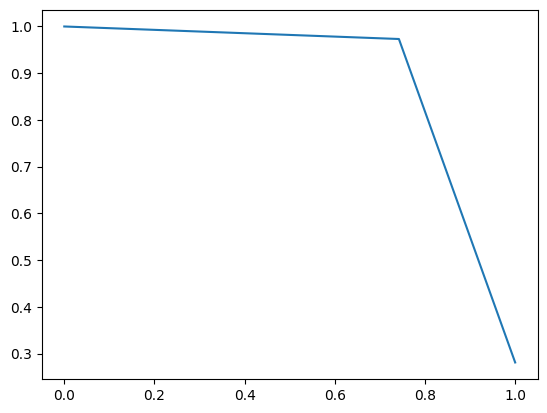

In [20]:
from sklearn.metrics import auc
# Data to plot precision - recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
import matplotlib.pyplot as plt
plt.plot(recall,precision)
plt.show()


In [21]:
no_features_during_fitting = model.n_features_in_ #10000. For checking the number of features.